## Python version of Gardner's lab tutorial on a channel response model

- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

#### Created by Daniela del Río, https://github.com/DanidelRio

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
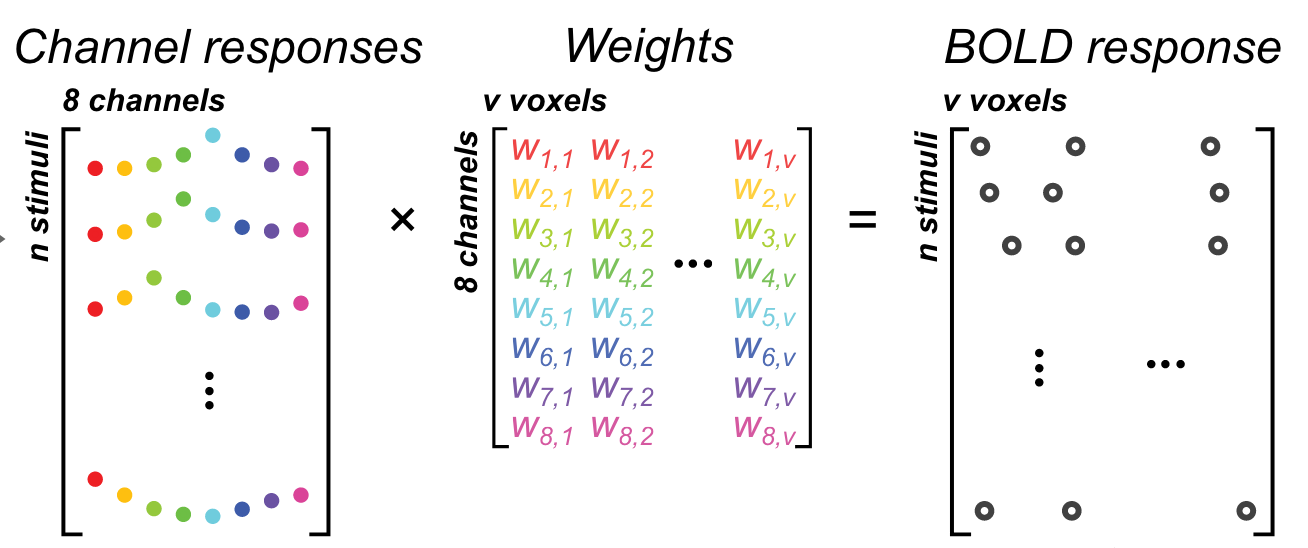

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

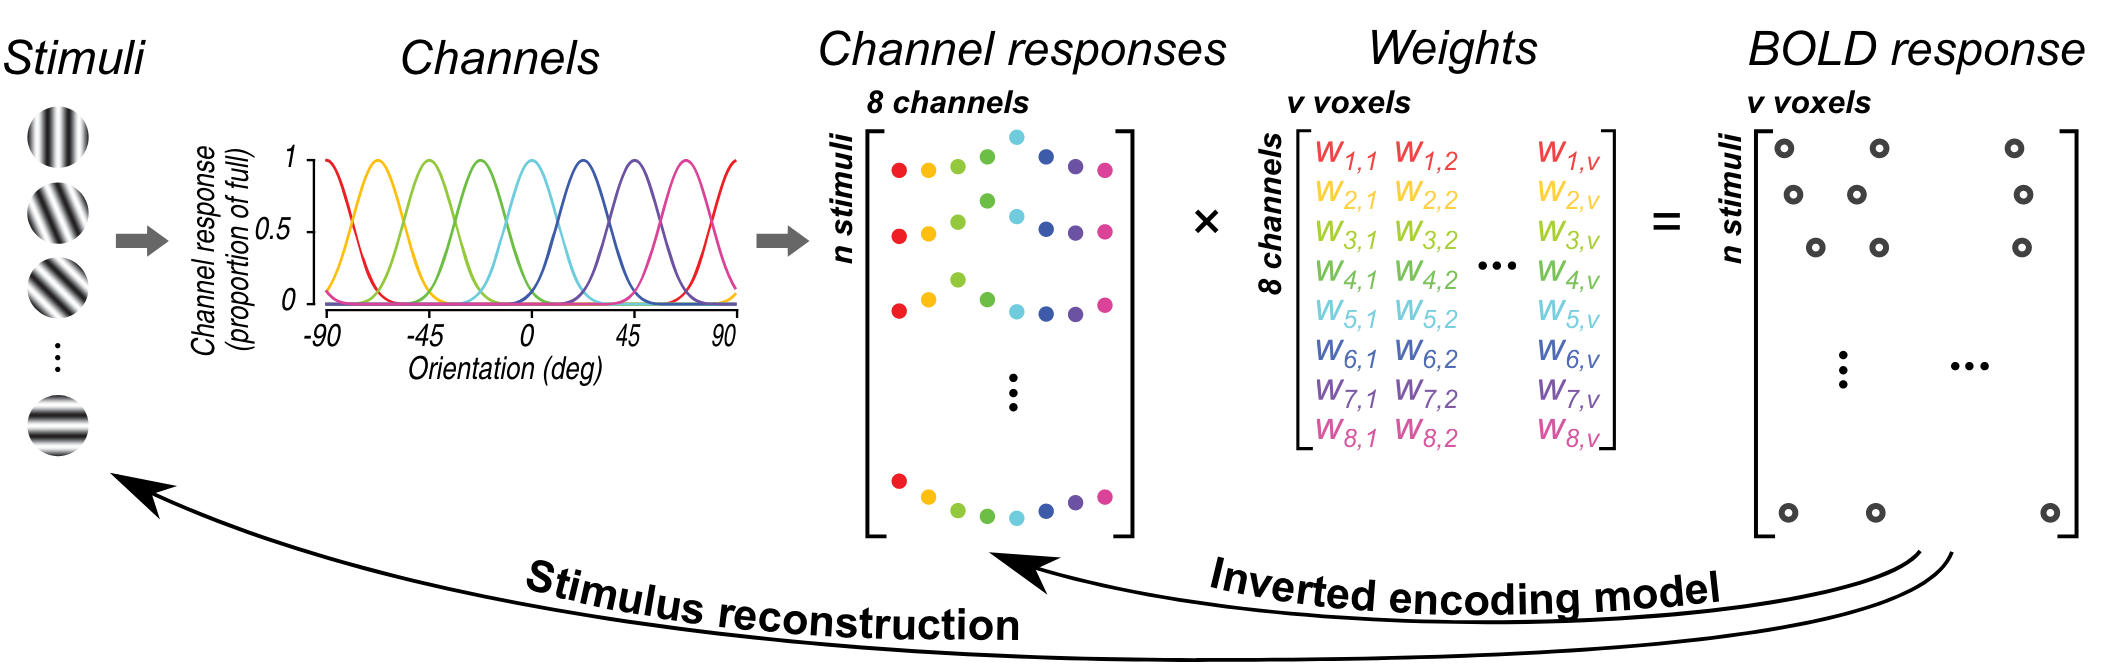
See Gardner and Liu, 2018.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from scipy.stats import multivariate_normal

### Simulated data (neural response to orientations)
Obtaining the channel response matrix.

In [2]:
k = 10
neurons = np.arange(0, 90) # 90 neurons

In [3]:
orientations = np.arange(0, 180) # 0-180 orientation
neuralResponse = np.zeros((len(neurons), len(orientations)))

# Loop over each neuron tuning function
for iNeuron in range(len(neurons)):
    
    orientPreference = 2*orientations[iNeuron] # orientation space mapped to 0-360
    
    # compute the neural response as a Von Mises function
    neuralResponse[iNeuron,:] = np.exp(k * np.cos (2*np.pi* (orientations-orientPreference)/180))
    # normalize
    neuralResponse[iNeuron,:] = neuralResponse[iNeuron,:] / np.max(neuralResponse[iNeuron,:])  

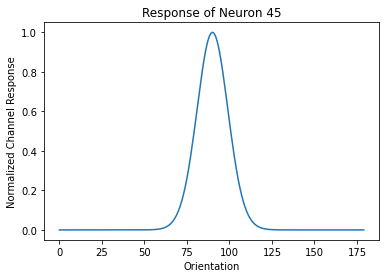

In [4]:
plt.plot(orientations, neuralResponse[45,:])
plt.title("Response of Neuron 45")
plt.xlabel("Orientation")
plt.ylabel("Normalized Channel Response")
plt.show()

Simulated voxel response

In [5]:
# Make a random weighting of neurons on to each voxel
nNeurons = len(neurons) # This is the same as np.shape(neuralResponse)[0]
# NOTE: The original tutorial in Matlab suggests using 250 voxels, but use 50 in the full_code.
nVoxels = 50

### `neuronToVoxelWeights`

Uniformly distributed random numbers

In [6]:
# size is nNeurons x nVoxels 
neuronToVoxelWeights = np.random.rand(nNeurons, nVoxels)

In [7]:
# Matlab verification
# However, importing the same values as the ones used in Matlab to compare the code,
# file = open("neuronToVoxelWeights.txt", "r")
# neuronToVoxelWeights = []

# for line in file.readlines():
#     entries = line.split(',')
#     entries_float = [float(element_i) for element_i in entries]

#     neuronToVoxelWeights.append(entries_float)

# file.close()
# neuronToVoxelWeights = np.asarray(neuronToVoxelWeights)

In [8]:
# Make stimulus array
nStimuli = 8

# evenly space stimuli
stimuli_1 = [i*180/nStimuli+1 for i in range(nStimuli)] # HERE! +1 because of the code structure in MAtlab

# number of repeats
nRepeats = 20

stimuli = np.asarray([stimuli_1 for i in range(nRepeats)]).reshape(1,nStimuli*nRepeats) # Dimensions 1 * 160

In [9]:
# Round and make a column array
stimuli = np.round(stimuli)
# Converting floats to integers so they can be referenced as indices
stimuli = stimuli.astype(np.int64)
# Note python indices start in 0 (unlike Matlab which start at 1)
# So it is not necessary to add 1.

Compute the `voxelResponse`

In [10]:
# neuralResponse is the response of 90 neurons to 180 angles.
# The stimuli we are interested in is: 0.,  22.,  45.,  68.,  90., 112., 135., 158
# Obtain the neuralResponse which corresponds to these stimuli values.

In [11]:
# compute the voxelResponse
nTrials = nStimuli * nRepeats # 160

# Initialize voxelResponse
voxelResponse = []

for iTrial in range(nTrials):
    # get the neural response to this stimulus, by indexing the correct column of the neuralResponse matrix
    thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]] # 1-D array, 90 elements
    
    # multiply this by the neuronToVoxelWeights to get the voxel response on this trial.
    # Note that you need to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
    voxelResponse.append(np.matmul(thisNeuralResponse, neuronToVoxelWeights))
    
voxelResponse = np.asarray(voxelResponse)
voxelResponse.shape # 160*50 matrix

(160, 50)

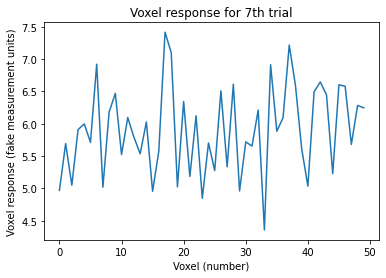

In [12]:
plt.plot(voxelResponse[6]) # Note 7 in Matlab is 6th in python!
plt.title('Voxel response for 7th trial')
plt.xlabel('Voxel (number)')
plt.ylabel('Voxel response (fake measurement units)')
plt.show()

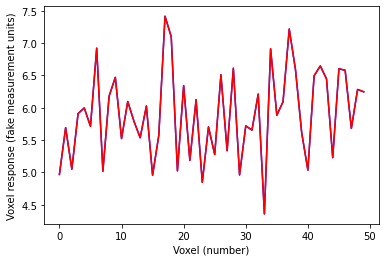

In [13]:
# plot another trial voxel response
plt.plot(voxelResponse[6,:], c="b")
plt.plot(voxelResponse[6+nStimuli,:],c='r')

plt.xlabel('Voxel (number)')
plt.ylabel('Voxel response (fake measurement units)')
plt.show()

### `voxelResponse`

Normally distributed random numbers

In [14]:
# add noise to the voxel responses
noiseStandardDeviation = 0.05

# NOTE! THIS IS NOT NORMALIZING!
# Scaling the reponse
voxelResponse = voxelResponse / np.mean(voxelResponse)

aux1, aux2 = voxelResponse.shape
# add gaussian noise
voxelResponse = voxelResponse + noiseStandardDeviation * np.random.randn(aux1, aux2)

In [15]:
# Matlab verification
# # Importing the same noise as the Matlab file

# # However, importing the same values as the ones used in Matlab to compare the code,
# file = open("voxelResponse.txt", "r")
# voxelResponse = []

# for line in file.readlines():
#     entries = line.split(',')
#     entries_float = [float(element_i) for element_i in entries]

#     voxelResponse.append(entries_float)

# file.close()
# voxelResponse = np.asarray(voxelResponse)

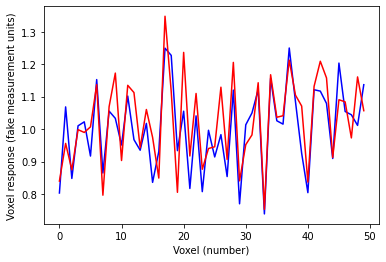

In [16]:
# Note again that python indices start in 0
stim1 = 6
stim2 = 2

plt.plot(voxelResponse[stim1,:],c="b")
plt.plot(voxelResponse[stim1+nStimuli,:], c="r")
plt.xlabel('Voxel (number)')
plt.ylabel('Voxel response (fake measurement units)')
plt.show()

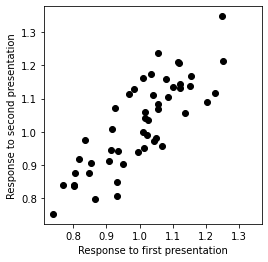

In [17]:
plt.scatter(voxelResponse[stim1,:], voxelResponse[stim1+nStimuli,:], c='k')
plt.xlabel('Response to first presentation')
plt.ylabel('Response to second presentation')
plt.axis('square')
plt.show()

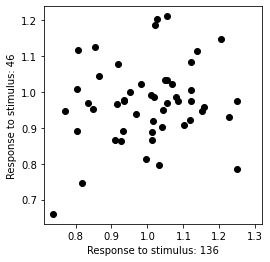

In [18]:
plt.scatter(voxelResponse[stim1], voxelResponse[stim2], c='k');
plt.xlabel('Response to stimulus: '+str(stimuli[0][stim1]))
plt.ylabel('Response to stimulus: '+str(stimuli[0][stim2]))
plt.axis('square')
plt.show()

Until here, "everything that we did in the simulation is an assumption: Von Mises tuned neurons, random linear weighting, IID noise and SNR (signal-to-noise ratio as in the magnitude of the orientation tuned response compared to the noise). Each of these may or may not be valid for real data and should ideally be tested (or at least thought about deeply!)."

### Encoding model

Based on the channel response and the voxel (BOLD) response matrices, fit the weight matrix. For example, using least-squares regression.

In [19]:
# make channel basis functions
nChannels = 8
exponent = 7
orientations = np.arange(0, 180)
prefOrientation = [i*180/nChannels for i in range(nChannels)]
# tuned as exponentials and rectified sinusoids to different orientations.

# channelBasis = []
channelBasis = np.zeros((180, nChannels)) # contains the ideal channel responses to each of 180 orientations

# loop over each channel
for iChannel in range(nChannels):
    # get sinusoid. Note the 2 here which makes it so that our 0 - 180 orientation
    # space gets mapped to all 360 degrees
    thisChannelBasis =  np.cos(2*np.pi*(orientations-prefOrientation[iChannel])/180)
    # rectify
    thisChannelBasis[thisChannelBasis<0] = 0
    # raise to exponent
    thisChannelBasis = thisChannelBasis**exponent
    # keep in matrix
    channelBasis[:,iChannel] = thisChannelBasis

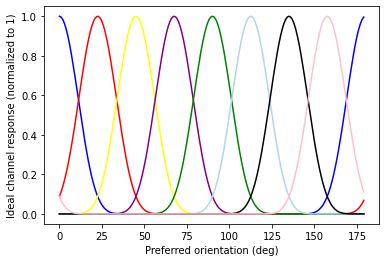

In [20]:
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nChannels):
    plt.plot(orientations, channelBasis[:,i], c=colors[i])

plt.xlabel('Preferred orientation (deg)')
plt.ylabel('Ideal channel response (normalized to 1)')
plt.show()

In [21]:
# compute the channelResponse for each trial
channelResponse = np.zeros((160, 8))

for iTrial in range(nTrials):
    channelResponse[iTrial, :] = channelBasis[stimuli[0][iTrial],:]

channelResponse.shape

(160, 8)

channelResponses (nTrials x nChannels) x estimatedWeights (nChannels x nVoxels) = voxelResponses (nTrials x nVoxels)

In [22]:
# Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse), voxelResponse)

### Model fit

Computing the goodness-of-fit of the model.

In [23]:
# compute model prediction
modelPrediction = np.matmul(channelResponse, estimatedWeights)
# compute residual
residualResponse = voxelResponse - modelPrediction
# compute r2
r2 = 1 - np.var(residualResponse) / np.var(voxelResponse)

print(r2)

0.8902113080381285


The notebook suggests you should obtain (80-90%).

### Inverted encoding model
Solving for the channel responses using the estimated weight matrix.

In [24]:
# Split the data in 2. Make 2 matrices from voxelData, trainVoxelResponse and testVoxelResponse.
# Compute estimatedWeights on trainVoxelResponse.

firstHalf = int(nTrials/2)
secondHalf = nTrials

trainVoxelResponse = voxelResponse[0:firstHalf, :]
testVoxelResponse = voxelResponse[firstHalf:secondHalf, :]

# compute weights on train data
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse[0:firstHalf]), trainVoxelResponse)

In [25]:
# compute channel response from textVoxelResponses
estimatedChannelResponse = np.matmul(testVoxelResponse, np.linalg.pinv(estimatedWeights))

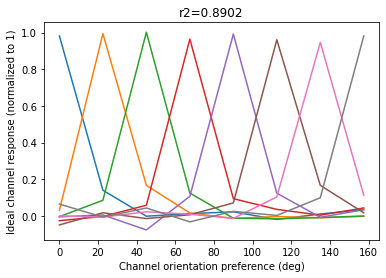

In [26]:
# Plot the mean estimatedChannelResponse for each stimulus type 
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nStimuli):
    vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
    means = np.mean(estimatedChannelResponse[vec_supplement,:], 0) # Mean across the first dimension
    plt.plot(prefOrientation, means)#, c=colors[i])

    plt.xlabel('Channel orientation preference (deg)')
plt.ylabel('Ideal channel response (normalized to 1)')
plt.title("r2="+str(round(r2, 4)))
plt.show()

In [27]:
# Compute voxel response without noise
nTrials = nStimuli * nRepeats
voxelResponseNoisy = []#np.zeros(nTrials, neuronToVoxelWeights.shape[1]) #160*50

for iTrial in range(nTrials):
    # get the neural response to this stimulus, by indexing the correct column of the neuralResponse matrix
    thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]]
    # multiply this by the neuronToVoxelWeights to get the voxel response on this trial. Note that you need
    # to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
    voxelResponseNoisy.append(np.matmul(thisNeuralResponse.T, neuronToVoxelWeights))

voxelResponseNoisy = np.asarray(voxelResponseNoisy)

### `voxelResponseNoisy`

Normally distributed random numbers

In [28]:
# add noise
noiseStandardDeviation = 0.5

# NOTE! THIS IS NOT NORMALIZING!
# Scaling the reponse
voxelResponseNoisy = voxelResponseNoisy / np.mean(voxelResponseNoisy)

aux1, aux2 = voxelResponseNoisy.shape
# add gaussian noise
voxelResponseNoisy = voxelResponseNoisy + noiseStandardDeviation * np.random.randn(aux1, aux2)

In [29]:
# Matlab verification

# # However, importing the same values as the ones used in Matlab to compare the code,
# file = open("voxelResponseNoisy.txt", "r")
# voxelResponseNoisy = []

# for line in file.readlines():
#     entries = line.split(',')
#     entries_float = [float(element_i) for element_i in entries]

#     voxelResponseNoisy.append(entries_float)

# file.close()
# voxelResponseNoisy = np.asarray(voxelResponseNoisy)

In [30]:
# split into train and tes
trainVoxelResponseNoisy = voxelResponseNoisy[0:firstHalf,:]
testVoxelResponseNoisy = voxelResponseNoisy[firstHalf:secondHalf,:]
 
# compute weights on train data
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse[0:firstHalf,:]), trainVoxelResponseNoisy)    
 
# compute model prediction on test data
modelPrediction = np.matmul(channelResponse[firstHalf:secondHalf,:], estimatedWeights)
# compute residual
residualResponse = testVoxelResponseNoisy - modelPrediction
# compute r2
r2 = 1 - np.var(residualResponse) / np.var(testVoxelResponseNoisy)
 
# invert model and compute channel response
estimatedChannelResponse = np.matmul(testVoxelResponseNoisy, np.linalg.pinv(estimatedWeights))

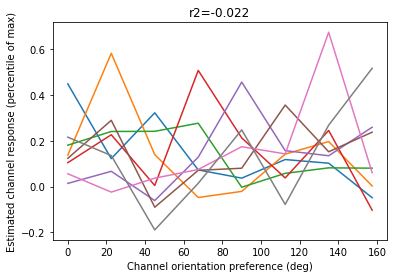

In [31]:
# Plot the estimated channel profiles
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nStimuli):
    vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
    means = np.mean(estimatedChannelResponse[vec_supplement,:], 0) # Mean across the first dimension
    plt.plot(prefOrientation, means)#, c=colors[i])

plt.xlabel('Channel orientation preference (deg)')
plt.ylabel('Estimated channel response (percentile of max)')
plt.title("r2="+str(round(r2, 4)))
plt.show()

### Stimulus likelihood

Using a simplified Bayesian algorithm to determine stimulus likelihood.

Note: Channel basis functions are only constrained up to a linear transform.

In [32]:
# split half into train and test
firstHalf = int(nTrials/2)
secondHalf = nTrials

trainVoxelResponse = voxelResponse[0:firstHalf, :]
testVoxelResponse = voxelResponse[firstHalf:secondHalf, :]

# compute weights on train data
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse[0:firstHalf]), trainVoxelResponse)
 
# compute model prediction on test data
modelPrediction = np.matmul(channelResponse[firstHalf:secondHalf,:], estimatedWeights)
# compute residual
residualResponse = testVoxelResponseNoisy - modelPrediction
# compute residual variance, note that this is a scalar
residualVariance = np.var(residualResponse)
 
# make this into a covariance matrix in which the diagonal contains the variance for each voxel
# and off diagonals (in this case all 0) contain covariance between voxels
modelCovar = np.identity(nVoxels) * residualVariance

In [33]:
# cycle over each trial
nTestTrials = np.size(testVoxelResponse,0)
likelihood = np.zeros([nTestTrials, len(orientations)])

for iTrial in range(nTestTrials):
  # now cycle over all possible orientations

  for iOrientation in range(len(orientations)):
    # compute the mean voxel response predicted by the channel encoding model
    predictedResponse = np.matmul(channelBasis[iOrientation], estimatedWeights)
    # now use that mean response and the model covariance to estimate the probability
    # of seeing this orientation given the response on this trial
    mvnpdf = multivariate_normal.pdf(testVoxelResponse[iTrial], mean=predictedResponse, cov = modelCovar)
    likelihood[iTrial,iOrientation] = mvnpdf

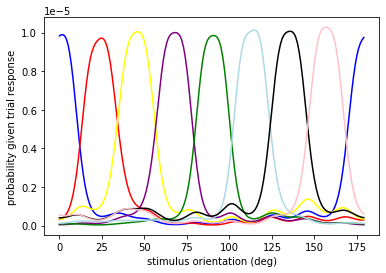

In [34]:
# Now, plotting the likelihood function averaged over repeats
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nStimuli):
    vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
    means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension

    plt.plot(means, c = colors[i])

plt.xlabel('stimulus orientation (deg)')
plt.ylabel('probability given trial response')
plt.show()

### Inverted encoding model with different channel basis functions

In [35]:
xform = np.zeros([nChannels, nChannels])

# reweight the channels
channelReweighting = np.asarray([0, 0.8, 0.4, 0, 0, 0, 0.4, 0.8]).T
xform = np.zeros([nChannels, nChannels])

# make into a full matrix xform to transform the original channels
for iChannel in range(nChannels):
    xform[iChannel,:] = np.roll(channelReweighting,iChannel)

# and get new bimodal channels
bimodalChannelBasis = np.matmul(channelBasis, xform)

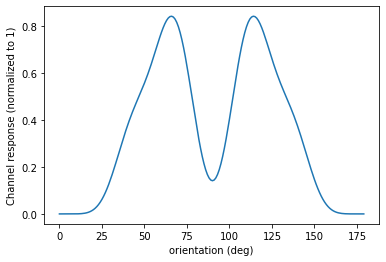

In [36]:
# display a figure with one of the channels
plt.plot(orientations, bimodalChannelBasis[:,4])
plt.xlabel('orientation (deg)')
plt.ylabel('Channel response (normalized to 1)')
plt.show()

In [37]:
# compute the channelResponse for each trial
for iTrial in range(nTrials):
    channelResponse[iTrial,:] = bimodalChannelBasis[stimuli[0][iTrial],:] #rewriting channelResponse

# Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse), voxelResponse)
 
# compute model prediction
modelPrediction = np.matmul(channelResponse, estimatedWeights)
# compute residual
residualResponse = voxelResponse - modelPrediction
# compute r2
r2 = 1 - np.var(residualResponse) / np.var(voxelResponse)

# invert model and compute channel response
estimatedChannelResponse = np.matmul(testVoxelResponse, np.linalg.pinv(estimatedWeights))

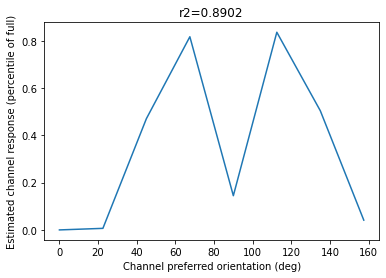

In [38]:
# and plot one of the channels averaged across all trials
vec_supplement = [iteration*nStimuli+4 for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
means = np.mean(estimatedChannelResponse[vec_supplement,:], 0) # Mean across the first dimension
plt.plot(prefOrientation, means)#, c=colors[i])

plt.xlabel('Channel preferred orientation (deg)')
plt.ylabel('Estimated channel response (percentile of full)')
plt.title("r2="+str(round(r2, 4)))
plt.show()

In [39]:
# compute weights on train data
estimatedWeights = np.matmul(np.linalg.pinv(channelResponse[0:firstHalf]), trainVoxelResponse) 

# compute model prediction on test data
modelPrediction = np.matmul(channelResponse[firstHalf:secondHalf], estimatedWeights)

# compute residual
residualResponse = testVoxelResponseNoisy - modelPrediction

# compute residual variance, note that this is a scalar
residualVariance = np.var(residualResponse)
 
# make this into a covariance matrix in which the diagonal contains the variance for each voxel
# and off diagonals (in this case all 0) contain covariance between voxels
modelCovar = np.identity(nVoxels) * residualVariance

In [40]:
# cycle over each trial
nTestTrials = np.size(testVoxelResponse,0)
likelihood = np.zeros([nTestTrials, len(orientations)])

for iTrial in range(nTestTrials):
  # now cycle over all possible orientations

  for iOrientation in range(len(orientations)):
    # compute the mean voxel response predicted by the channel encoding model
    predictedResponse = np.matmul(bimodalChannelBasis[iOrientation], estimatedWeights)
    # now use that mean response and the model covariance to estimate the probability
    # of seeing this orientation given the response on this trial
    mvnpdf = multivariate_normal.pdf(testVoxelResponse[iTrial], mean=predictedResponse, cov = modelCovar)
    likelihood[iTrial,iOrientation] = mvnpdf

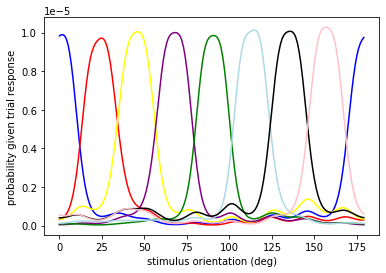

In [41]:
# Now, plotting the likelihood function averaged over repeats
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nStimuli):
    vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
    means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension

    plt.plot(means, c = colors[i])

plt.xlabel('stimulus orientation (deg)')
plt.ylabel('probability given trial response')
plt.show()